# Generating Embeddings for Protein Clustering

In this example we will use the BioNeMo Framework to show how to
* Set up the essential BioNeMo building blocks for ML inference  
  * Launch a BioNeMo Docker container  
  * Prepare data
  * Download pretrained models   
  * Launch an inference server for a pretrained model using gRPC  
* Run inference on protein sequence data  
* Walk through a protein sequence clustering task with example data  
  * Extract embeddings  
  * Build simple vizualisations  
  * Perform a Clustering task with the embeddings  

## Prerequisites:
Please familiarize yourself with the following components prior to starting with this notebook:  
- BioNeMo Framework container setup (refer to the [Quickstart Guide](../quickstart-fw.md))
- Familiarity with some components of the BioNeMo framework such as the [Models](../models/esm2nv.md) and [Inferencing](../inference-grpc-fw.md)

### Launch a Docker container  
Once you have successfully set up the BioNeMo Framework Docker image following the 'Setup' instructions at [Quickstart Guide](../quickstart-fw.md), identify the image ID by running 'docker images' and finding the correct BioNeMo image that you've downloaded.  
With the required model name, model path details, you can now run the container locally with `docker run -it -p 8888:8888 --gpus all -v <model directory>:<mount destination> <BioNeMo_Image> <model>`. This command will set up a 'Jupyter Lab' that can be found on `localhost:8888`. 

_This example has been built upon a container running in a local machine with 2 x A6000 RTX GPUs. Refer to specific instructions for [remote and multinode launch](../inference-grpc-fw.md)._

### Prepare data  

ESM2-nv can be used to run inference on protein sequence data, resulting in embeddings.  
In this example, we will work with a sample csv file with sequence data from the UniRef50 dataset. Our sample dataset consists of 5,001 proteins, and is available within the BioNeMo Framework GitHub repository at the following location: `/examples/tests/test_data/uniref202104_esm2_qc`

The stored data is stored in zip file, so run the following the command to extract the various pre-training and inference files.  

In [ ]:
!unzip -o /workspace/bionemo/examples/tests/test_data/uniref202104_esm2_qc.zip -d /workspace/bionemo/examples/tests/test_data/

For the purpose of this inference example, we simply use the ```uniref50_inference_example.csv``` file. This file is a two-column, comma-separated file where the first column is the sequence IDs and the second column is the protein sequences.  


### Download pre-trained Models

BioNeMo Framework comes with the basic building blocks for ML inference, namely the NeMo optimized pre-trained ML models and the framework to use these models for pre-training and inference. We also provide a set of scripts to download these models from NVIDIA NGC.  
As of the pre-release version (01 NOV 2023), we have the following models available:

- Molecule/MegaMolBART
- Protein/ESM-1nv
- Protein/ESM-2nv: 650M and 3B variants.
- Protein/ProtT5nv

In your active Docker container, **download the pre-trained models** with 

`./launch.sh download`

The command above will invoke a routine that downloads the models from published addresses in `download_bionemo_models`.

Once execution is complete, you will see files with the `.nemo` extension within the folder specified in the `MODEL_PATH=${MODEL_PATH:=${PROJECT_PATH}/<DIRECTORY>}` configuration of your `.env` file. 

Refer to the [Quickstart Guide](../quickstart-fw.md) for configuring your Docker container and for more info about the `.env` file.

#### Configuring paths in your active container   

> **.nemo Files**   
> Make sure the models downloaded are within the desired project mount directory such as `/models/protein/esm2nv`; otherwise, you may have to move the `.nemo` files, such as `esm2nv_650M_converted.nemo` from wherever it has been downloaded into.    

> **Jupyter Lab's Workspace**   
> If you type `pwd` in the Jupyter Lab's terminal, this may not show BioNeMo's original directory in your machine but yet another directory such as `/workspace`, according to the project mount directory you've set in the `.env` file. 

#### Setting up the notebook in your active container  

In this example, we will be working with the [ESM2-nv model](../models/esm2-nv.md) and a subset of the UniRef50 data (5k proteins) available in the BioNeMo framework.

ESM-2nv was developed using the BioNeMo framework. The model uses an architecture called Bidirectional Encoder Representations from Transformers (BERT) and is based on the ESM-2 model 

You could run the code as provided in the cells below - into a Jupyter Notebook launched from the JupyterLab interface running inside the container. For that, you should first run the following two steps on your terminal: 

1. Copy the notebook to the example directory of ESM2-nv:
```bash
cp protein-esm2nv-clustering.ipynb /workspace/bionemo/examples/esm2nv/nbs
```
2. Launch a gRPC client with the ESM2-nv-650M model:
```bash
python3 -m bionemo.model.protein.esm1nv.grpc.service --model esm2nv_650M
```

## Run inference on protein sequence data   

Once the gRPC client is launched with your pre-trained model of choice, the BioNeMo-way is simple to generate embeddings:

In [ ]:
# Initalize the Inference Wrapper that will invoke the pre-trained model
esm = ESMInferenceWrapper()
# Work with a set of sequences (these are invalid sequences despite valid amino-acids)
sequence_examples = ["TRANSCENDINGLIMITS", "MASTERMINDING"]
# Generate Embeddings
embeddings = esm.seq_to_embedding(sequence_examples)

# Print the shape of embeddings
print(f"Shape of embeddings (2, 1280): {embeddings.shape}")

This requires fewer lines of code than, for example, [Rostlab's Example in Hugging Face](https://huggingface.co/Rostlab/prot_t5_xl_uniref50). This is because the `ESMInferenceWrapper` BioNeMo class takes care of the tokenization process and handles the configuration of the hidden states.  

## Protein sequence clustering example
Since we are now familiar with the basic building blocks of the BioNeMo Framework to generate protein embeddings, let's tackle and example including data vizualization and clustering with the UniRef50 sample data.

To perform this in an efficient manner, we will utilize open-source CUDA accelerated data science and machiene learning libraries such as cuML, cuDF, cuPY. For more information, check out [NVIDIA RAPIDS](https://rapids.ai/). 

[cuDF](https://github.com/rapidsai/cudf) provides a pandas-like API that will be familiar to data engineers & data scientists, so they can use it to easily accelerate their workflows without going into the details of CUDA programming. Similarly, [cuML](https://github.com/rapidsai/cuml) enables data scientists, researchers, and software engineers to run traditional tabular ML tasks on GPUs. In most cases, cuML's Python API matches the API from scikit-learn.

:::{note}
The following cells containing python code snippets can be directly copied and executed into a Python environment such as a Jupyter notebook running in a BioNemo container.
:::

In [1]:
!which python

/bin/python


In [12]:
%%time
import cudf                     # Using cudf from NVIDIA RAPIDS
import cupy as cp               # To process arrays on the GPU
import cuml                     # We will use DBSCAN for clustering with unkown labels and clusters
import numpy as np              # numpy for simple array manipulations
import matplotlib.pyplot as plt # Matplotlib for data vizualization
import pandas as pd             # simple dataframe manipulation
import torch                    # To deal with tensors

# bionemo utils
from bionemo.data import UniRef50Preprocess
from infer import ESMInferenceWrapper

# Dimensionality reduction algorithm 
from cuml.manifold import TSNE as cumlTSNE
from sklearn.preprocessing import StandardScaler

ModuleNotFoundError: No module named 'bionemo'

> For this example, we will use a small dataset of 5k proteins that we share in the BioNeMo FW and that can be found at `/examples/tests/test_data/uniref202104_esm2_q`

In [24]:
%%time
import os

data_path = "/workspace/bionemo/examples/tests/test_data/uniref202104_esm2_qc"
sequence_df = pd.read_csv(os.path.join(data_path, "uniref50_inference_example.csv"), sep=",", header=0)

CPU times: user 12.9 ms, sys: 2.59 ms, total: 15.5 ms
Wall time: 14.8 ms


In [25]:
sequence_df.head()

,record_name,sequence
0,UniRef50_A0A007,MGYIHTALKSAGFHHVIQVDTPALGLDSEGLRKLLADFEPDLVGVS...
1,UniRef50_A0A009DWD5,MGAKLTNHDPNKMALIESINYFNKYYQQDIKIYEAVLKP
2,UniRef50_A0A009DWJ5,MAMQHVTDRATRMIHHSGRGSQYCSELYQSALRHYGVCPSMTDGGDC
3,UniRef50_A0A009DY31,MEHAREQRVKRTQRDYSFAFKMMVVHEVEKGQITYKQAQAKYGNLSSI
4,UniRef50_A0A009DYA3,MISETCYRYQAKLSDDNTFIAEQLIELTEENPDWSFGLCFSYLQHV...


Let's have a look on the sample dataset...  

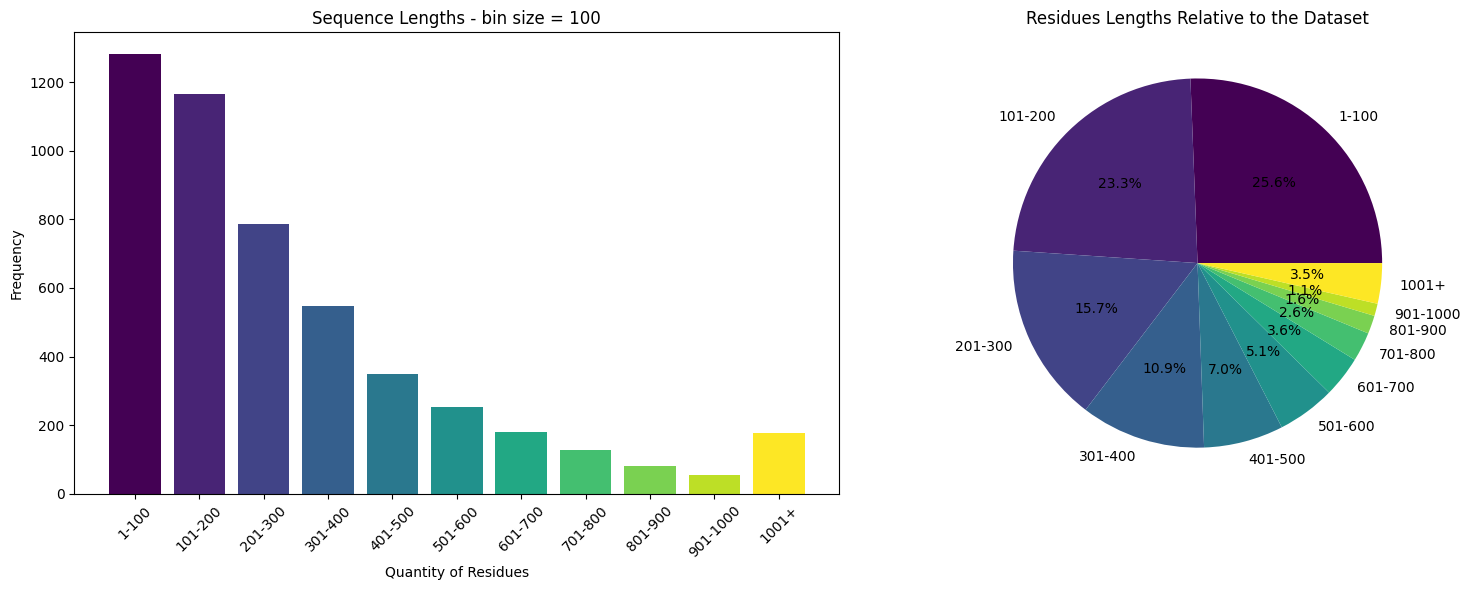

CPU times: user 201 ms, sys: 140 ms, total: 341 ms
Wall time: 173 ms


In [26]:
%%time
# Define the bin function
def bin_data(s, start, end, step):
    # Create the bins
    bins = list(range(start, end+1, step)) + [np.inf]

    # Create the labels
    labels = [f'{i+1}-{i+step}' for i in range(start, end, step)] + ['1001+']
    
    # Cut the Series
    s_cut = pd.cut(s, bins=bins, labels=labels, include_lowest=True, right=False)
    
    return s_cut

# Let's create a column to capture the sequence lengths  
sequence_df['sequence_length'] = [len(m) for m in sequence_df.sequence]  

# we'll work with the sequences and their lengths
s = sequence_df.sequence_length.to_numpy()

# Bin the data
s_binned = bin_data(s, start=0, end=1000, step=100)

# Count the frequency of each bin
s_counts = s_binned.value_counts()

# Generate colors from the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(s_counts)))

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Create the bar plot on the first subplot
axs[0].bar(s_counts.index, s_counts.values, color=colors)
axs[0].set_title('Sequence Lengths - bin size = 100')
axs[0].set_xlabel('Quantity of Residues')
axs[0].set_ylabel('Frequency')
axs[0].tick_params(axis='x', rotation=45)

# Create the pie chart on the second subplot
axs[1].pie(s_counts.values, labels=s_counts.index, autopct='%1.1f%%', colors=colors)
axs[1].set_title('Residues Lengths Relative to the Dataset')

# Display the plots
plt.tight_layout()
plt.show()

### ESM-2nv limits 
The current limit for ESM-2nv is 1023 Residues based on the nemo checkpoints, so we will have to decrease the dataset accordingly.

### Data Cleaning

We can also ignore the test and validation sets for this example (since we're not training a model). 
 
In this example, we will use two groups of proteins:

1. Up to 100 amino acids, which can include functional types such as 

 - **Regulatory Peptides**: For example, Insulin, with 51 amino acids.

 - **Neuropeptides**: Small protein-like molecules used by neurons to communicate with each other. Substance P, a neuropeptide involved in pain perception, contains 11 amino acids.

 - **Antimicrobial Peptides**: These are an essential part of the innate immune response and have antibiotic properties. An example is defensins, which typically contain 18-45 amino acids.

 - **Toxins**: Many toxins produced by plants, animals, and bacteria are small peptides. For example, Melittin, the main toxin in bee venom, has 26 amino acids.

 - **Cytokines**: Some small cytokines, often referred to as chemokines, have less than 100 amino acids. An example is Interleukin-8 (IL-8), a chemokine produced by macrophages, with 99 amino acids.


2. Between 400 and 1000 amino acids, with functional types such as

    - **G-Protein Coupled Receptors (GPCRs)**: This is a large family of proteins that span the cell membrane and receive signals from outside the cell. GPCRs are involved in a vast number of physiological processes and they typically have around 350-1000 amino acids.

    - **Ion Channels**: Ion channels are a class of proteins that allow ions to pass through the membrane in response to a signal. The length of these proteins varies. Some are within the 400-1000 amino acid range, while others are up to 4,000 amino acids.

    - **Cytochrome P450 Enzymes**: These enzymes are involved in the metabolism of various molecules and chemicals within cells. They are typically around 400-500 amino acids long.

    - **Serine/Threonine Protein Kinases**: This is a large family of enzymes that catalyze the addition of a phosphate group to serine or threonine residues in other proteins. While the length varies significantly, many members of this family are within the 1,000 amino acid range.

    - **GTPases**: These are a family of hydrolase enzymes that can bind and hydrolyze guanosine triphosphate (GTP). The proteins are critical regulators of a wide variety of cellular processes. Smaller GTPase proteins are 400-500 amino acids in length, with larger GTPases having lengths around 800 amino acids.

In [31]:
%%time
sequence_df = sequence_df[(sequence_df.sequence_length < 100) | ((sequence_df.sequence_length > 400) &  (sequence_df.sequence_length < 1000))]
print("Max seq. length (sample dataset)", sequence_df.sequence_length.max())
print("Length of dataset", len(sequence_df))

Max seq. length (sample dataset) 997
Length of dataset 2323
CPU times: user 0 ns, sys: 911 µs, total: 911 µs
Wall time: 804 µs


In [29]:
sequence_df.head()

,record_name,sequence,sequence_length
0,UniRef50_A0A007,MGYIHTALKSAGFHHVIQVDTPALGLDSEGLRKLLADFEPDLVGVS...,407
1,UniRef50_A0A009DWD5,MGAKLTNHDPNKMALIESINYFNKYYQQDIKIYEAVLKP,39
2,UniRef50_A0A009DWJ5,MAMQHVTDRATRMIHHSGRGSQYCSELYQSALRHYGVCPSMTDGGDC,47
3,UniRef50_A0A009DY31,MEHAREQRVKRTQRDYSFAFKMMVVHEVEKGQITYKQAQAKYGNLSSI,48
4,UniRef50_A0A009DYA3,MISETCYRYQAKLSDDNTFIAEQLIELTEENPDWSFGLCFSYLQHV...,50


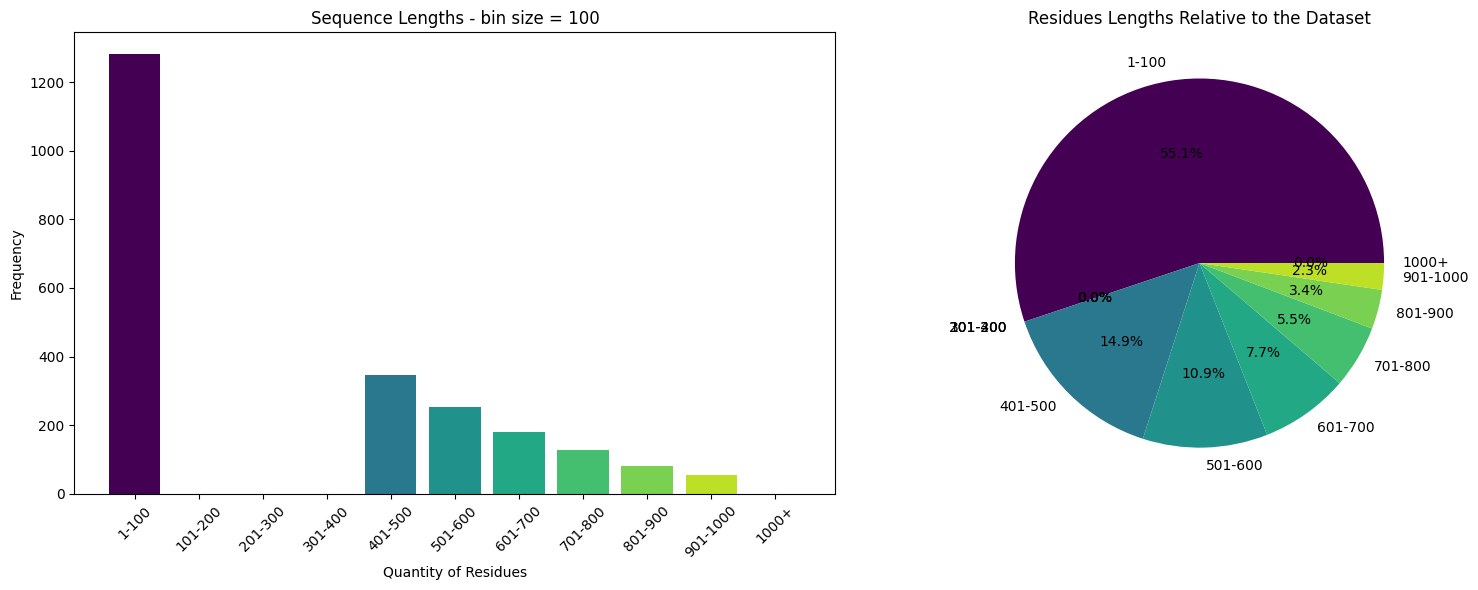

CPU times: user 189 ms, sys: 152 ms, total: 340 ms
Wall time: 170 ms


In [30]:
%%time
# Define the bin function
def bin_data(s, start, end, step):
    # Create the bins
    bins = list(range(start, end+1, step)) + [np.inf]

    # Create the labels
    labels = [f'{i+1}-{i+step}' for i in range(start, end, step)] + ['1000+']
    
    # Cut the Series
    s_cut = pd.cut(s, bins=bins, labels=labels, include_lowest=True, right=False)
    
    return s_cut

# we'll work with the sequences and their lengths
s = sequence_df.sequence_length.to_numpy()

# Bin the data
s_binned = bin_data(s, start=0, end=1000, step=100)

# Count the frequency of each bin
s_counts = s_binned.value_counts()

# Generate colors from the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(s_counts)))

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Create the bar plot on the first subplot
axs[0].bar(s_counts.index, s_counts.values, color=colors)
axs[0].set_title('Sequence Lengths - bin size = 100')
axs[0].set_xlabel('Quantity of Residues')
axs[0].set_ylabel('Frequency')
axs[0].tick_params(axis='x', rotation=45)

# Create the pie chart on the second subplot
axs[1].pie(s_counts.values, labels=s_counts.index, autopct='%1.1f%%', colors=colors)
axs[1].set_title('Residues Lengths Relative to the Dataset')

# Display the plots
plt.tight_layout()
plt.show()

**Using the Inference Wrapper**  

We will obtain the embeddings for the desired sequences based on the pre-trained models we have previously downloaded. 

To avoid memory issues, we'll submit sequences individually. 

In this exampe we are creating a embeddings vectors to be clustered. We know the vector's dimension by ESM-2nv models specifications. 

**Defines a Scaling Function**

In [10]:
%%time
# Initalize the Inference Wrapper that will invoke the pre-trained model
esm = ESMInferenceWrapper()

# Defines the number of samples per amino acid group
samples = 500
# Set the hidden dim for ESM2nv-650M model
hidden_dim = 1280

# Creates a balanced dataset
indexes_100 = np.random.choice(len(sequence_df[sequence_df.sequence_length < 100]),samples,replace=False)
indexes_400 = np.random.choice(len(sequence_df[sequence_df.sequence_length > 400]),samples,replace=False)
balanced_samples = [*indexes_100, *indexes_400]

# Initializes an embeddings tensor
prot_embeddings = torch.empty(len(balanced_samples), hidden_dim, dtype=torch.float32).cuda()

# Build the embeddings tensor based on mean pooling
for _, i in enumerate(balanced_samples):
    # Obtain embeddings. 
    embeddings = esm.seq_to_embedding(sequence_df.sequence.to_arrow().to_pylist()[i])
    prot_embeddings[_,:] = embeddings.mean(dim=0)

CPU times: user 30.7 s, sys: 4.13 s, total: 34.8 s
Wall time: 2min 4s


In [11]:
# Auxiliary matrix shape (to be used in clustering) must be (2 x samples, 1280)
prot_embeddings.shape

torch.Size([1000, 1280])

**DBSCAN**

Script extracted from RAPIDS API tutorial.

More information available at: https://docs.rapids.ai/api/cuml/stable/api/#clustering

Num. Of Clusters:  2


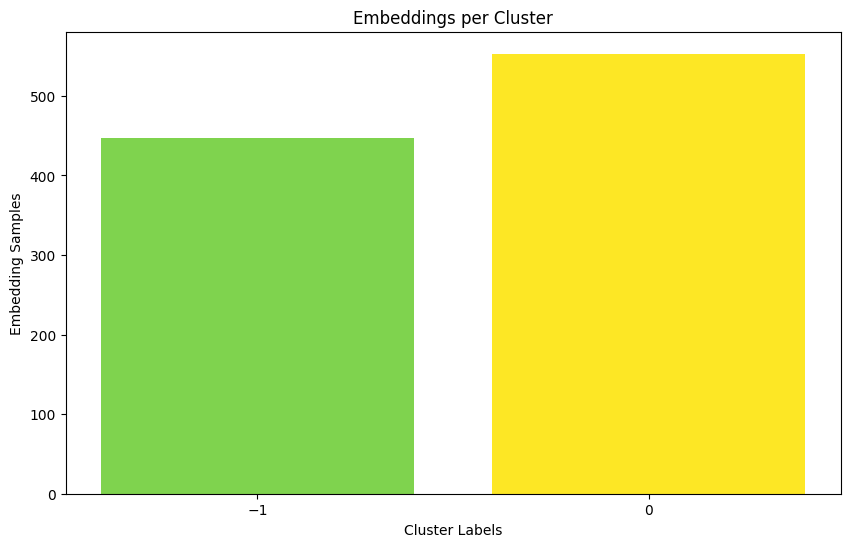

CPU times: user 279 ms, sys: 89.6 ms, total: 368 ms
Wall time: 291 ms


In [12]:
%%time
ary = cp.asarray(prot_embeddings)
prev_output_type = cuml.global_settings.output_type
cuml.set_global_output_type('cudf')
dbscan_float = cuml.DBSCAN(eps=.48, min_samples=50)
dbscan_float.fit(ary)
cuml.set_global_output_type(prev_output_type)
print("Num. Of Clusters: ", dbscan_float.labels_.nunique())

import matplotlib.ticker as ticker
labels = dbscan_float.labels_.values.get()

# Count the number of samples in each cluster
unique_labels, counts = np.unique(labels, return_counts=True)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, counts, color=plt.cm.viridis(counts / float(max(counts))))
plt.xlabel('Cluster Labels')
plt.ylabel('Embedding Samples')
plt.title('Embeddings per Cluster')

# Ensure all labels are displayed on x-axis and they are integers
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.set_xticks(unique_labels)

plt.show()

Using T-SNE to reduce dimensionality so that we can visualize the clusters of data

[NeMo W 2023-11-01 20:04:14 nemo_logging:349] /usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
      return func(**kwargs)
    


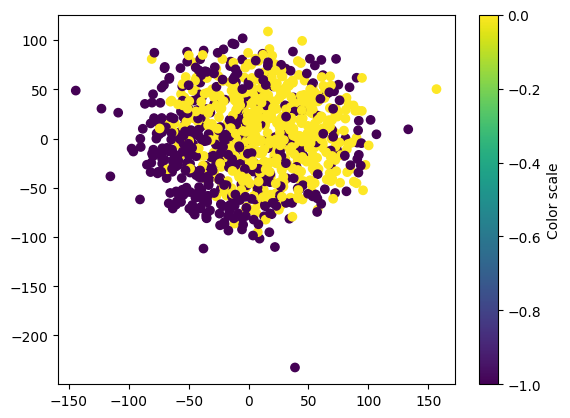

CPU times: user 758 ms, sys: 181 ms, total: 939 ms
Wall time: 736 ms


In [13]:
%%time
# Hyperparameters picked arbitrarily for this example
tsne = cumlTSNE(n_components=2, perplexity=6, learning_rate=100, random_state=42)
tsne_embedding = cudf.DataFrame(tsne.fit_transform(ary))

# Create scatterplot
colors = dbscan_float.labels_.values.get()
plt.scatter(tsne_embedding.iloc[:,0].to_numpy(), tsne_embedding.iloc[:,1].to_numpy(), c=colors)
# Add a colorbar
plt.colorbar(label='Color scale')
# Show plot
plt.show()

The plot above is for the sake of exemplification based on a subset of random proteins and should not be representative of a full application.

# Conclusion

In this example, you saw how simple it is to operate with BioNeMo and integrate it with classic clustering and dataframe manipulation activities.